## What is SIFT doing?
I will give a very simplified, intuitive, visual description of the SIFT algorithm here.

For a nice overview of SIFT with pictures, see https://gilscvblog.com/2013/08/18/a-short-introduction-to-descriptors/

For an in-depth explanation, see http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

For the deepest depth, read the original academic paper https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf

### Difference of Gaussians
If you’ve messed with Photoshop or GIMP you know what a Gaussian blur is. You set the “size” of the blur in pixels – this number is also called sigma. Then you get a uniformly blurred image.

The Difference of Gaussians (DoG) is easy to do in Photoshop/GIMP. First greyscale the image. Then duplicate the layer a few times and do a Gaussian Blur on each one with a different sigma value. Finally, set the layer blending mode to “Difference” for all the layers, and look at any 2 layers.

“Difference” simply subtracts the pixel intensities of corresponding pixels: difference[x][y] = layer1[x][y] - layer2[x][y].

I did this with my stereo octopus image. Here are a few DoG results:

### Keypoint detection
Now with the edges removed, we will go over different image scales and find at which scale an interesting blob is best represented. In image classification literature, the scale of a feature is called the “octave”. So for each interesting blob we save its octave, x, and y coordinates as a keypoint.

### Rotation normalization
We want to be able to match features regardless of their orientation, so that we can match a part of an eye or tentacle no matter how the eye or tentacle is rotated. To solve this problem, SIFT features are assigned an “orientation” based on the pixel intensities of the surrounding area.

Essentially, you can imagine that we have some rule about orientation – for example, we could make a rule that the direction pointing from the center of the feature to brightest region of neighboring pixels is selected as a feature’s “orientation” direction. Then we turn the feature so that “orientation” (the brightest region) is pointing upwards. Now all similar features will “line up” with each other, even if they are rotated differently in the images they come from.

In [9]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

print 'OpenCV Version (should be 3.1.0, with nonfree packages installed, for this tutorial):'
print cv2.__version__

# I cropped out each stereo image into its own file.
# You'll have to download the images to run this for yourself
octo_front = cv2.imread('images1.jpg')
octo_offset = cv2.imread('images.jpeg')

def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

OpenCV Version (should be 3.1.0, with nonfree packages installed, for this tutorial):
3.4.0


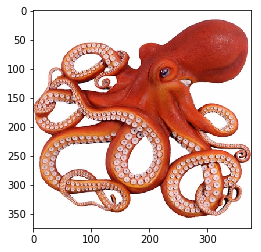

In [10]:
show_rgb_img(octo_front);

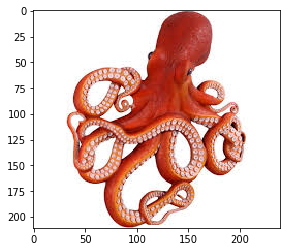

In [11]:
show_rgb_img(octo_offset);

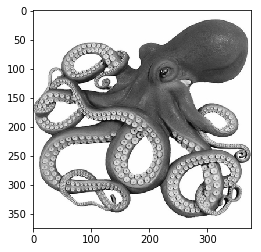

In [12]:
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

octo_front_gray = to_gray(octo_front)
octo_offset_gray = to_gray(octo_offset)

plt.imshow(octo_front_gray, cmap='gray');


Here are what our SIFT features look like for the front-view octopus image:


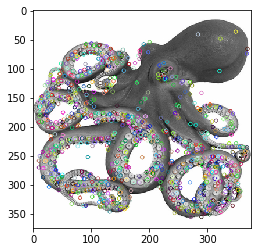

In [13]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

# generate SIFT keypoints and descriptors
octo_front_kp, octo_front_desc = gen_sift_features(octo_front_gray)
octo_offset_kp, octo_offset_desc = gen_sift_features(octo_offset_gray)

print 'Here are what our SIFT features look like for the front-view octopus image:'
show_sift_features(octo_front_gray, octo_front, octo_front_kp);


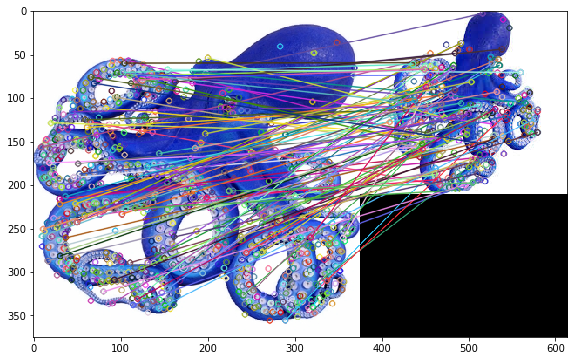

In [14]:
# create a BFMatcher object which will match up the SIFT features
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(octo_front_desc, octo_offset_desc)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    octo_front, octo_front_kp,
    octo_offset, octo_offset_kp,
    matches[:N_MATCHES], octo_offset.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

In [15]:
octo_front_desc[0]


array([ 12.,  16.,   4.,  12.,  15.,  34.,  18.,  15.,  67.,  24.,  15.,
        24.,  28.,  41.,   3.,   3., 190.,  22.,   1.,   0.,   0.,   0.,
         0.,  26.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  32.,
        78.,  16.,  12.,  23.,  44.,  24.,   9.,  92.,  33.,  10.,  25.,
       116.,  67.,   6.,   7., 190.,  54.,   1.,   2.,   5.,   4.,   1.,
        10.,  80.,   2.,   0.,   0.,   0.,   0.,   0.,   3.,  25.,  43.,
        15.,  17.,   9.,  43.,  21.,  23.,  73.,  29.,   6.,   9.,  62.,
       110.,  17.,  32., 190.,   5.,   0.,   1.,   8.,  18.,   5.,  62.,
        90.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  17.,  21.,  10.,
        12.,  11.,  52.,  29.,  16.,  47.,  19.,   6.,   7.,  20.,  29.,
        32.,  17., 190.,   1.,   0.,   1.,   5.,   6.,   1.,  21.,  66.,
         1.,   0.,   0.,   0.,   0.,   0.,   1.], dtype=float32)

In [16]:
print len(octo_front_kp), 'keypoints in the list'
print octo_front_kp[0]

973 keypoints in the list
<KeyPoint 0x7f1a6c958210>


In [17]:
def explain_keypoint(kp):
    print 'angle\n', kp.angle
    print '\nclass_id\n', kp.class_id
    print '\noctave (image scale where feature is strongest)\n', kp.octave
    print '\npt (x,y)\n', kp.pt
    print '\nresponse\n', kp.response
    print '\nsize\n', kp.size

print 'this is an example of a single SIFT keypoint:\n* * *'
explain_keypoint(octo_front_kp[0])

this is an example of a single SIFT keypoint:
* * *
angle
220.012115479

class_id
-1

octave (image scale where feature is strongest)
8651008

pt (x,y)
(9.142985343933105, 156.74835205078125)

response
0.0468880608678

size
4.04955291748


In [18]:
print 'SIFT descriptors are vectors of shape', octo_front_desc[0].shape
print 'they look like this:'
octo_front_desc[0]

SIFT descriptors are vectors of shape (128,)
they look like this:


array([ 12.,  16.,   4.,  12.,  15.,  34.,  18.,  15.,  67.,  24.,  15.,
        24.,  28.,  41.,   3.,   3., 190.,  22.,   1.,   0.,   0.,   0.,
         0.,  26.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  32.,
        78.,  16.,  12.,  23.,  44.,  24.,   9.,  92.,  33.,  10.,  25.,
       116.,  67.,   6.,   7., 190.,  54.,   1.,   2.,   5.,   4.,   1.,
        10.,  80.,   2.,   0.,   0.,   0.,   0.,   0.,   3.,  25.,  43.,
        15.,  17.,   9.,  43.,  21.,  23.,  73.,  29.,   6.,   9.,  62.,
       110.,  17.,  32., 190.,   5.,   0.,   1.,   8.,  18.,   5.,  62.,
        90.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  17.,  21.,  10.,
        12.,  11.,  52.,  29.,  16.,  47.,  19.,   6.,   7.,  20.,  29.,
        32.,  17., 190.,   1.,   0.,   1.,   5.,   6.,   1.,  21.,  66.,
         1.,   0.,   0.,   0.,   0.,   0.,   1.], dtype=float32)

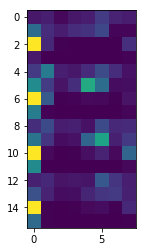

In [19]:
# visualized another way:
plt.imshow(octo_front_desc[0].reshape(16,8), interpolation='none');